# RFF+SVS preliminary tests

**Not implemented**
* GPU usage (just set device to conda).
* Optimal initilization of bandwidths.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.style.use('figures/pyselect.mplstyle')

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
torch.cuda.is_available()

True

### Hadamard Layer

In [5]:
class HadamardLayer(nn.Module):

    # TODO: consistent broadcasting, bandwidth initialization, named tensors
    def __init__(self, in_features):
        """Hadamard layer of bandwidths with constant (val = 0)
        initialization.
        """
        super(HadamardLayer, self).__init__()
        self.in_features = in_features
        self.bandwidths = nn.Parameter(torch.Tensor(in_features))
        self.reset_parameters()
        
    def forward(self, x):
        return x * self.bandwidths 
    
    def reset_parameters(self):
        nn.init.constant_(self.bandwidths, 0)
    
    def __repr__(self):
        return(f"HadamardLayer(in_features={self.in_features})")

### RFF Layer

In [6]:
class RFFLayer(nn.Module):
    
    # TODO: parameter tracking (is bw tracked?), named tensors
    def __init__(self, in_features, out_features, sampler):
        """Random Fourier Features layer."""
        super(RFFLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self._omega_sample = sampler(self.in_features, self.out_features)
        self._unif_sample = torch.rand(self.out_features)*2*np.pi
    
    def forward(self, x):
        norm = torch.tensor(2.0/self.out_features) # normalizing factor for LLN.
        output = torch.sqrt(norm)*torch.cos(x @ self._omega_sample + self._unif_sample)
        return output     
    
    def __repr__(self):
        return(f"RFFLayer(in_features={self.in_features}, out_features={self.out_features})")
        

### RFF Net

In [7]:
class RFFNet(nn.Module):

    # TODO: final layer can be set to a different architecture.
    def __init__(self, in_features, R, sampler):
        """Neural network specification."""
        super(RFFNet, self).__init__()
        self.rff_net = nn.Sequential(
                HadamardLayer(in_features),
                RFFLayer(in_features, R, sampler),
                nn.Linear(R, 1, bias=False)
        )
        
    def forward(self, x):
        output = self.rff_net(x)
        return output
    

## Synthetic Data

In [8]:
def data_synthesizer(sample_size, n_features, n_relevant_features,
                    param_range=np.array([-1, 1]), sd=1):
    X = torch.rand(sample_size, n_features)
    true_beta = torch.zeros(n_features)
    relevant_feat = np.random.choice(n_features, n_relevant_features, replace=False) # sample indexes of relevant features
    true_beta[relevant_feat] = param_range[0] + param_range.ptp() * torch.randn(n_relevant_features) # set relevant features to param_range
    y = X @ true_beta.unsqueeze_(-1) + sd*torch.randn(sample_size).unsqueeze(-1)
    return X, y, true_beta

In [9]:
def se1_data(sample_size, n_features=18, sd=0.1):
    X = torch.randn(sample_size, n_features)
    y = (torch.sin((X[:,0] + X[:, 2])**2)*torch.sin(X[:,6]*X[:,7]*X[:,8])).unsqueeze(-1)+ sd*torch.randn(sample_size).unsqueeze(-1)
    return X, y

In [10]:
n_samples = 2000

In [11]:
n_features = 18

In [12]:
n_relevant_features = 5

In [13]:
#X, y, true_beta = data_synthesizer(n_samples, n_features=n_features, n_relevant_features=n_relevant_features)
X, y = se1_data(n_samples, n_features)

## Training

### Training/Test split

In [14]:
training_frac = 0.5

In [15]:
training_size = int(training_frac*n_samples)

In [16]:
shuffled_indices = torch.randperm(n_samples)
train_indices, val_indices = shuffled_indices[:-training_size], shuffled_indices[-training_size:]

In [17]:
X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]

### Model specification

In [18]:
R = 300

In [19]:
#sampler = lambda n_in, n_out: torch.from_numpy(stats.cauchy.rvs(loc=0, scale=1, size=(n_in, n_out))).to(dtype=torch.float32)
sampler = torch.randn

In [20]:
rff_model = RFFNet(n_features, R, sampler)

In [21]:
rff_model

RFFNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=18)
    (1): RFFLayer(in_features=18, out_features=300)
    (2): Linear(in_features=300, out_features=1, bias=False)
  )
)

**Parameters**

In [22]:
rff_model

RFFNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=18)
    (1): RFFLayer(in_features=18, out_features=300)
    (2): Linear(in_features=300, out_features=1, bias=False)
  )
)

In [23]:
optim = torch.optim.SGD(rff_model.parameters(), lr=1e-3) # plain SGD, no momentum

In [24]:
loss_fn = torch.nn.MSELoss() 

In [25]:
train_loss_history = []
val_loss_history = []

In [26]:
def save_model(logpath, loss_val_history, loss_train_history, model, optimizer, epoch, state):
    torch.save({'loss_val_history': loss_val_history,
                    'loss_train_history': loss_train_history,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'state': state}, logpath)

In [27]:
def training_loop(n_epochs, optimizer, model, loss_fn, X_train, y_train, X_val, y_val):
    loss_val_history = []
    loss_train_history = []
    for epoch in range(1, n_epochs+1):
        y_train_pred = model(X_train)
        loss_train = loss_fn(y_train_pred, y_train)
        y_val_pred = model(X_val)

        loss_val = loss_fn(y_val_pred, y_val)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        loss_val_history.append(loss_val.item())
        loss_train_history.append(loss_train.item())

        if epoch == 1 or epoch % 2000 == 0:
            print(f"Epoch {epoch}, Training loss {np.sqrt(loss_train_history[-1]):.7f}, \
                Validation loss {np.sqrt(loss_val_history[-1]):.7f}")
    return loss_train_history, loss_val_history
      

In [28]:
n_epochs = 42*10**3

In [29]:
loss_train_history, loss_val_history = training_loop(n_epochs=n_epochs,
                                        model=rff_model,
                                        optimizer=optim,
                                        loss_fn=loss_fn,
                                        X_train=X_train, 
                                        y_train=y_train, 
                                        X_val=X_val, 
                                        y_val=y_val)

Epoch 1, Training loss 0.2984929,                 Validation loss 0.2866661
Epoch 2000, Training loss 0.2842178,                 Validation loss 0.2816782
Epoch 4000, Training loss 0.2842073,                 Validation loss 0.2818041
Epoch 6000, Training loss 0.2841996,                 Validation loss 0.2818023
Epoch 8000, Training loss 0.2841919,                 Validation loss 0.2817988
Epoch 10000, Training loss 0.2841842,                 Validation loss 0.2817955
Epoch 12000, Training loss 0.2841764,                 Validation loss 0.2817923
Epoch 14000, Training loss 0.2841685,                 Validation loss 0.2817892
Epoch 16000, Training loss 0.2841604,                 Validation loss 0.2817861
Epoch 18000, Training loss 0.2841521,                 Validation loss 0.2817833
Epoch 20000, Training loss 0.2841434,                 Validation loss 0.2817806
Epoch 22000, Training loss 0.2841343,                 Validation loss 0.2817780
Epoch 24000, Training loss 0.2841248,           

## Visualization

### Training

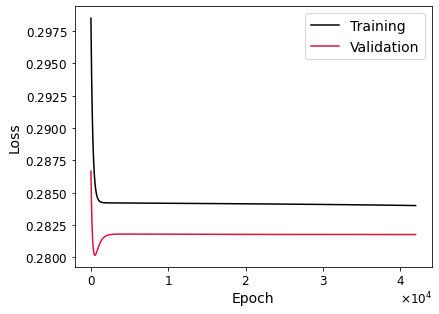

In [30]:
plt.plot(np.sqrt(loss_train_history), color='k', label='Training')
plt.plot(np.sqrt(loss_val_history), color='crimson', label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Bandwidths

In [31]:
params = list(rff_model.parameters())

In [32]:
bandwidths = params[0].data.numpy()

In [33]:
beta_est_array = params[1].data.numpy()

In [34]:
bins = np.linspace(bandwidths.min(), bandwidths.max(), 18)

In [35]:
n_features, n_relevant_features, R

(18, 5, 300)

In [36]:
relevant = torch.tensor([0, 2, 6, 7, 8])

In [37]:
irrelevant = [i for i in range(0, 18) if i not in relevant]

In [38]:
irrelevant

[1, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17]

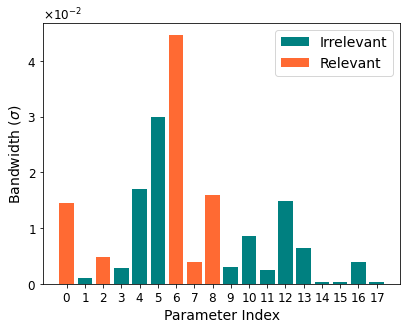

In [39]:
plt.bar(irrelevant, np.abs(bandwidths[irrelevant]), color='teal', label="Irrelevant")
plt.bar(relevant, np.abs(bandwidths[relevant]), alpha=0.8, color='orangered', label="Relevant", zorder=20)
ax = plt.gca()
ax.set_xlabel("Parameter Index")
ax.set_ylabel("Bandwidth ($\sigma$)")
ax.set_xticks(list(range(0, 18)))
plt.legend(loc='best')
plt.show()

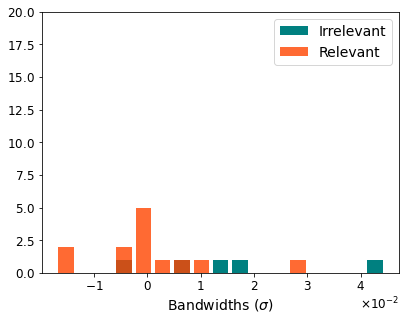

In [40]:
plt.hist(bandwidths[relevant], bins=bins, rwidth=0.8, color='teal', label="Irrelevant")
plt.hist(bandwidths[irrelevant], bins=bins, rwidth=0.8, alpha=0.8, color='orangered', label="Relevant", zorder=20)
ax = plt.gca()
ax.set_xlabel("Bandwidths ($\sigma$)")
plt.legend(loc='best')
plt.ylim(0, 20)
plt.show()